Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Microsoft\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Microsoft\AppData\Local\Temp\ipykernel_14372\493124511.py", line 99, in apply_changes
    self.update_callback(pos, mom, sigma)
  File "C:\Users\Microsoft\AppData\Local\Temp\ipykernel_14372\493124511.py", line 169, in update_simulation
    self.reset_animation()
  File "C:\Users\Microsoft\AppData\Local\Temp\ipykernel_14372\493124511.py", line 157, in reset_animation
    self.update_frame()
  File "C:\Users\Microsoft\AppData\Local\Temp\ipykernel_14372\493124511.py", line 176, in update_frame
    self.anim._draw_next_frame()
TypeError: Animation._draw_next_frame() missing 2 required positional arguments: 'framedata' and 'blit'
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Microsoft\anaconda3\Lib\tkinter\__init__.py", line 1948, in _

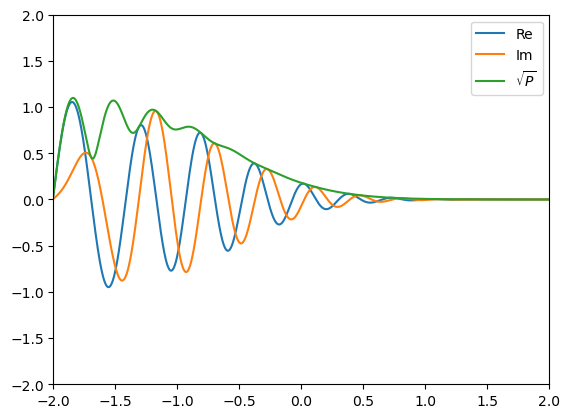

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import messagebox
from matplotlib.animation import FuncAnimation

x = np.linspace(-10, 10, 5000)
deltax = x[1] - x[0]

def norm(phi):
    norm = np.sum(np.square(np.abs(phi))) * deltax
    return phi / np.sqrt(norm)

def complex_plot(x, y, prob=True, **kwargs):
    real = np.real(y)
    imag = np.imag(y)
    a, *_ = plt.plot(x, real, label='Re', **kwargs)
    b, *_ = plt.plot(x, imag, label='Im', **kwargs)
    plt.xlim(-2, 2)
    if prob:
        p, *_ = plt.plot(x, np.abs(y), label='$\sqrt{P}$')
        return a, b, p
    else:
        return a, b

def wave_packet(pos=0, mom=0, sigma=0.2):
    return norm(np.exp(-1j * mom * x) * np.exp(-np.square(x - pos) / sigma / sigma, dtype=complex))

def d_dxdx(phi, x=x):
    dphi_dxdx = -2 * phi
    dphi_dxdx[:-1] += phi[1:]
    dphi_dxdx[1:] += phi[:-1]
    return dphi_dxdx / deltax

def d_dt(phi, h=1, m=100, V=0):
    return 1j * h / 2 / m * d_dxdx(phi) - 1j * V * phi / h

def euler(phi, dt, **kwargs):
    return phi + dt * d_dt(phi, **kwargs)

def rk4(phi, dt, **kwargs):
    k1 = d_dt(phi, **kwargs)
    k2 = d_dt(phi + dt / 2 * k1, **kwargs)
    k3 = d_dt(phi + dt / 2 * k2, **kwargs)
    k4 = d_dt(phi + dt * k3, **kwargs)
    return phi + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def simulate(phi_sim, method='rk4', V=0, steps=100000, dt=1e-1, condition=None, normalize=True, save_every=100):
    simulation_steps = [np.copy(phi_sim)]
    for i in range(steps):
        if method == 'euler':
            phi_sim = euler(phi_sim, dt, V=V)
        elif method == 'rk4':
            phi_sim = rk4(phi_sim, dt, V=V)
        else:
            raise Exception(f'Unknown method {method}')
        if condition:
            phi_sim = condition(phi_sim)
        if normalize:
            phi_sim = norm(phi_sim)
        if save_every is not None and (i + 1) % save_every == 0:
            simulation_steps.append(np.copy(phi_sim))
    return simulation_steps

box_potential = np.where((x > -2) & (x < 2), 0, 1)
sim_box_mom = simulate(wave_packet(mom=10), V=box_potential, steps=100000, save_every=500)

class ParameterAdjustmentApp:
    def __init__(self, master, update_callback):
        self.master = master
        master.title("Parameter Adjustment")

        self.update_callback = update_callback

        self.pos_label = tk.Label(master, text="Position (pos):")
        self.pos_label.grid(row=0, column=0)
        self.pos_entry = tk.Entry(master)
        self.pos_entry.grid(row=0, column=1)

        self.mom_label = tk.Label(master, text="Momentum (mom):")
        self.mom_label.grid(row=1, column=0)
        self.mom_entry = tk.Entry(master)
        self.mom_entry.grid(row=1, column=1)

        self.sigma_label = tk.Label(master, text="Sigma (sigma):")
        self.sigma_label.grid(row=2, column=0)
        self.sigma_entry = tk.Entry(master)
        self.sigma_entry.grid(row=2, column=1)

        self.apply_button = tk.Button(master, text="Apply", command=self.apply_changes)
        self.apply_button.grid(row=3, columnspan=2)

    def apply_changes(self):
        try:
            pos = float(self.pos_entry.get())
            mom = float(self.mom_entry.get())
            sigma = float(self.sigma_entry.get())
            self.update_callback(pos, mom, sigma)
        except ValueError:
            messagebox.showerror("Error", "Invalid input. Please enter valid numbers.")

class SimulationApp:
    def __init__(self, master):
        self.master = master
        master.title("Wave Packet Simulation")

        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.fig, master=master)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

        self.sim_box_mom = sim_box_mom
        self.anim = None
        self.current_frame = 0

        self.toolbar_frame = tk.Frame(master)
        self.toolbar_frame.pack(side=tk.BOTTOM)

        self.play_button = tk.Button(self.toolbar_frame, text="Play", command=self.play_animation)
        self.play_button.pack(side=tk.LEFT)

        self.pause_button = tk.Button(self.toolbar_frame, text="Pause", command=self.pause_animation)
        self.pause_button.pack(side=tk.LEFT)

        self.reset_button = tk.Button(self.toolbar_frame, text="Reset", command=self.reset_animation)
        self.reset_button.pack(side=tk.LEFT)

        self.parameter_adjustment_button = tk.Button(master, text="Adjust Parameters", command=self.adjust_parameters)
        self.parameter_adjustment_button.pack(side=tk.BOTTOM)

    def create_animation(self):
        def update(frame):
            prob.set_ydata(np.abs(self.sim_box_mom[frame]))
            re.set_ydata(np.real(self.sim_box_mom[frame]))
            im.set_ydata(np.imag(self.sim_box_mom[frame]))
            return prob, re, im

        re, im, prob = complex_plot(x, self.sim_box_mom[0])
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.legend()
        self.anim = FuncAnimation(self.fig, update, frames=len(self.sim_box_mom), blit=True, interval=50)

    def play_animation(self):
        if self.anim:
            self.anim.event_source.start()
            self.master.after(50, self.update_frame)

    def pause_animation(self):
        if self.anim:
            self.anim.event_source.stop()

    def reset_animation(self):
        if self.anim:
            self.anim.event_source.stop()
            self.current_frame = 0
            self.update_frame()

    def adjust_parameters(self):
        parameter_window = tk.Toplevel(self.master)
        parameter_app = ParameterAdjustmentApp(parameter_window, self.update_simulation)

    def update_simulation(self, pos, mom, sigma):
        new_wave_packet = wave_packet(pos, mom, sigma)
        self.sim_box_mom = simulate(new_wave_packet, V=box_potential, steps=100000, save_every=500)
        if self.anim is None:
            self.create_animation()
        else:
            self.reset_animation()

    def update_frame(self):
        if self.anim is not None:
            self.current_frame += 1
            if self.current_frame < len(self.sim_box_mom):
                self.anim.frame_seq = self.anim.new_frame_seq()
                self.anim._draw_next_frame()
                self.master.after(50, self.update_frame)
            else:
                self.current_frame = 0
                self.anim.event_source.stop()

if __name__ == "__main__":
    root = tk.Tk()
    app = SimulationApp(root)
    root.mainloop()
